In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import os
import re
import pathlib
from PIL import Image
import numpy as np

# Path 지정

In [3]:
root_dir = pathlib.Path('.')
input_dir = root_dir / 'input'
data_dir = input_dir /'data'
train_dir = data_dir / 'train'
eval_dir = data_dir / 'eval'

# 데이터 살펴보기

In [4]:
train_info = pd.read_csv(train_dir / 'train.csv')
train_info.head(5)

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59


## column 확인

In [5]:
train_info['race'].unique()

array(['Asian'], dtype=object)

In [6]:
train_info['gender'].unique()

array(['female', 'male'], dtype=object)

In [7]:
min(train_info['age'].unique()),max(train_info['age'].unique())

(18, 60)

## 데이터 전처리

- gender 데이터 integer 변환

In [8]:
train_info['gender'] = train_info['gender'].replace({'female':0,'male':1})

- 나이에 따른 데이터 분포

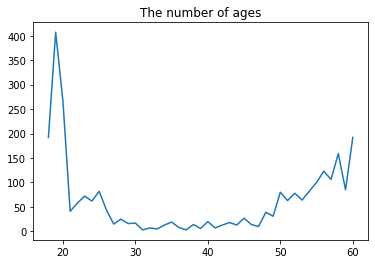

In [9]:
plt.title("The number of ages")
plt.plot(train_info.groupby('age')['id'].count())
plt.show()

- `ages` (나이대 정보) 추가

In [10]:
train_info['ages'] = train_info['age'].map(lambda x: x//10*10)

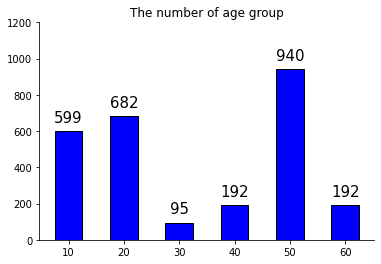

In [11]:
x = sorted(train_info['ages'].unique())
y = train_info.groupby('ages')['id'].count().sort_index()

fig,ax = plt.subplots()
ax.bar(x,y,width=5,color='blue',edgecolor='black')

for x_index in x:
     ax.text(x_index,y[x_index]+50,y[x_index],fontsize=15,ha='center')
        
for spine in ['top','right']:
    ax.spines[spine].set_visible(False)
ax.set_title('The number of age group')
ax.set_ylim(0,1200)

plt.show()

30,40,60 대의 데이터가 다른 분포에 비해 적다.

- `ages_class` 추가
    - [10,30) : 0 class
    - [30~60) : 1 class
    - [60~) : 2 class

In [12]:
train_info['ages_class'] = train_info['ages'].apply(lambda x : 0 if x>=10 and x<30 else 1 if x>=30 and x<60 else 2)

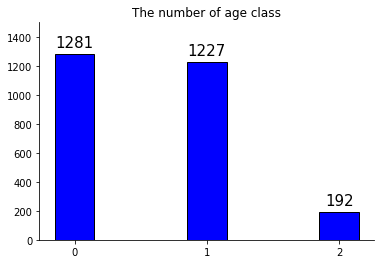

In [13]:
x = sorted(train_info['ages_class'].unique())
y = train_info.groupby('ages_class')['id'].count().sort_index()

fig,ax = plt.subplots()
ax.bar(x,y,width=0.3,color='blue',edgecolor='black')

for x_index in x:
     ax.text(x_index,y[x_index]+50,y[x_index],fontsize=15,ha='center')
        
for spine in ['top','right']:
    ax.spines[spine].set_visible(False)
ax.set_title('The number of age class')
ax.set_xticks(x)
ax.set_ylim(0,1500)

plt.show()

label의 분포로 봤을 때는 2class(60대 이상)의 데이터가 현저히 부족하다.

## 데이터 확인

mask input/data/train/images/000001_female_Asian_45/mask2.jpg
mask input/data/train/images/000001_female_Asian_45/mask3.jpg
mask input/data/train/images/000001_female_Asian_45/mask4.jpg
mask input/data/train/images/000001_female_Asian_45/mask5.jpg
mask input/data/train/images/000001_female_Asian_45/mask1.jpg
mask input/data/train/images/000001_female_Asian_45/normal.jpg
mask input/data/train/images/000001_female_Asian_45/incorrect_mask.jpg


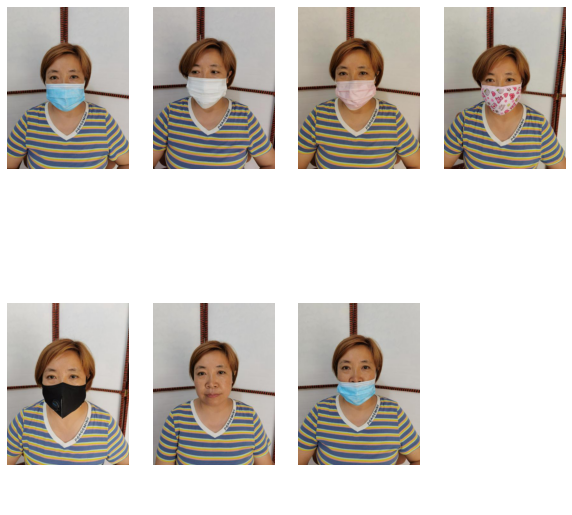

In [14]:
for path in train_info['path']:
    file_path = train_dir/'images'/path
    fig,axes = plt.subplots(2,4,figsize=(10,10))
    axes = axes.flatten()
    axes_idx=0
    for file in file_path.glob('mask*.jpg'):
        print('mask' , file)
        image = Image.open(file)
        axes[axes_idx].imshow(image)
        axes_idx+=1
    for file in file_path.glob('normal*.jpg'):
        print('mask' , file)
        image = Image.open(file)
        axes[axes_idx].imshow(image)
        axes_idx+=1
    for file in file_path.glob('incorrect_*.jpg'):
        print('mask' , file)
        image = Image.open(file)
        axes[axes_idx].imshow(image)
        axes_idx+=1
    
    for ax in axes:
        ax.set_axis_off()
    break

# Further Question

### input이 될 X에 대한 분석 X는 Image가 됩니다. X에 대한 특성(feature)은 어떤 것이 있을까요??

In [15]:
data_path = train_dir/'images'/train_info['path'][0]
mask_data = Image.open(list(data_path.glob("mask*"))[0])
print(mask_data)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=384x512 at 0x7F1F66E07280>


- image shape

In [53]:
import torchvision
tensor_image = torchvision.transforms.ToTensor()(mask_data)
tensor_image.shape

torch.Size([3, 512, 384])

- channel별 std

In [18]:
tensor_image.std(dim=1).std(dim=1)

tensor([0.0261, 0.0248, 0.0315])

# 데이터 로드

In [40]:
from tqdm import tqdm
class MaskTrainDataSet(torch.utils.data.Dataset):
    def __init__(self,data_dir=pathlib.Path('/opt/ml/input/data/train/images'),transform=None,device='cpu'):
        self.data_dir = data_dir
        self.transform=transform
        self.device=device

        self.X,self.y = self.load_data(self.data_dir,transform,device)
        
    def __len__(self):
        return len(self.X)
    def __getitem__(self,index):
        return self.X[index],self.y[index]
    
    def load_data(self,data_dir,transform,device):
    # gender labeling : { female : 0, male : 1 }
    # age labeling : { [10,30) : 0, [30,60) : 1, [60,~) : 2}
    # mask labeling : { mask : 0, normal : 1, incorrect : 2 }
        gender_labeling={
            'female':0,
            'male':1
        }
        age_labeling={
            10:0,
            20:0,
            30:1,
            40:1,
            50:1,
            60:2
        }
        mask_labeling={
            'mask':0,
            'normal':1,
            'incorrect':2
        }
        X=[]
        y=[]
        for files_path in tqdm(list(data_dir.glob('[0-9]*'))):
            _,gender,_,age = files_path.parts[-1].split('_')
            age = int(age)//10 * 10
            for file_path in files_path.glob('mask*'):
                image = Image.open(file_path)
                if transform:
                    image = transform(image)
                X.append(image)
                y.append([mask_labeling['mask'],gender_labeling[gender],age_labeling[age]])

            for file_path in files_path.glob('normal*'):
                image = Image.open(file_path)
                if transform:
                    image = transform(image)
                X.append(image)
                y.append([mask_labeling['normal'],gender_labeling[gender],age_labeling[age]])

            for file_path in files_path.glob('incorrect*'):
                image = Image.open(file_path)
                if transform:
                    image = transform(image)
                X.append(image)
                y.append([mask_labeling['incorrect'],gender_labeling[gender],age_labeling[age]])
                
        X= torch.stack(X).to(device)
        y = torch.tensor(y,dtype=torch.long).to(device)
        print(X.shape,y.shape)
        return X,y

- 데이터의 전체 용량이 너무 커서 한번에 로딩하는 것이 어렵다 !!
    - `__init__`에서 데이터를 전부 로딩하는 것이 아닌 `__getitem__`할 때마다 불러오는 형식으로 수정해야겠다.

In [42]:
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_data = MaskTrainDataSet(transform=torchvision.transforms.
                        Compose([torchvision.transforms.Resize((224,224)),torchvision.transforms.ToTensor()])
                                ,device=device)

  0%|          | 3/2700 [00:00<01:40, 26.90it/s]

>>>>> /opt/ml/input/data/train/images


100%|██████████| 2700/2700 [05:40<00:00,  7.93it/s]  


torch.Size([18900, 3, 224, 224]) torch.Size([18900, 3])


In [43]:
train_loader = torch.utils.data.DataLoader(train_data,shuffle=True,batch_size=64)

- 데이터가 잘 loading되었나 확인하기 위해 이미지 출력

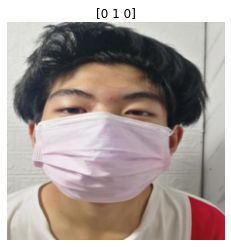

In [55]:
x,y= next(iter(train_loader))
plt.imshow(x[0].permute(1,2,0).detach().cpu().numpy())
plt.title(y[0].detach().cpu().numpy())
plt.axis('off')
plt.show()

## y값 분석

In [50]:
train_df = pd.DataFrame(train_data.y.detach().cpu().numpy(),columns=['masking','gender','age_group'])

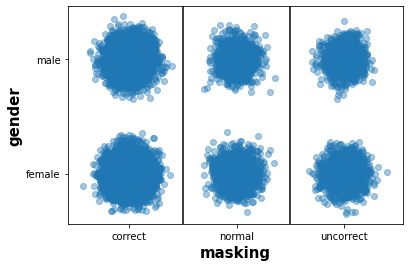

                age_group
masking gender           
0       0            8290
        1            5210
1       0            1658
        1            1042
2       0            1658
        1            1042


In [51]:
# masking값과 성별값 간의 데이터 분포도를 확인
# 값의 분포를 그래프로 확인할 수 있게하기 위해서 약간의 noise 적용
plt.scatter(train_df['masking'] + np.random.normal(0,1e-1,*train_df['masking'].shape).T,train_df['gender'] + np.random.normal(0,1e-1,*train_df['gender'].shape).T,alpha=0.4)

plt.xticks(sorted(train_df['masking'].unique()),['correct','normal','uncorrect'])
plt.yticks(sorted(train_df['gender'].unique()),['female','male'])

plt.xlabel('masking',fontweight='bold',fontsize=15)
plt.ylabel('gender',fontweight='bold',fontsize=15)

plt.axvline(x=0.5,color='black')
plt.axvline(x=1.5,color='black')

plt.show()

print(train_df.groupby(['masking','gender']).count())

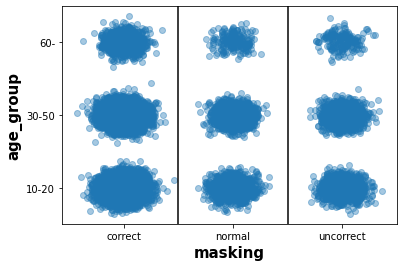

                   gender
masking age_group        
0       0            6405
        1            6135
        2             960
1       0            1281
        1            1227
        2             192
2       0            1281
        1            1227
        2             192


In [52]:
# masking값과 age_group 간의 데이터 분포도를 확인
plt.scatter(train_df['masking'] + np.random.normal(0,1e-1,*train_df['masking'].shape).T,train_df['age_group'] + np.random.normal(0,1e-1,*train_df['age_group'].shape).T,alpha=0.4)

plt.xticks(sorted(train_df['masking'].unique()),['correct','normal','uncorrect'])
plt.yticks(sorted(train_df['age_group'].unique()),['10-20','30-50','60-'])

plt.xlabel('masking',fontweight='bold',fontsize=15)
plt.ylabel('age_group',fontweight='bold',fontsize=15)

plt.axvline(x=0.5,color='black')
plt.axvline(x=1.5,color='black')

plt.show()

print(train_df.groupby(['masking','age_group']).count())

각 y값 간의 차이가 분명하게 존재하기는 하지만 편향된 데이터 수집으로 인해 해당 값이 유의미한 결과를 나타내지는 않는다!